In [1]:
from Preprocess import *
from Model import *
from DataAnalysis import *

## Read data and make dictionary

In [2]:
dic_csv = read_data()
df_var = make_dataframe(dic_csv)

## Concat train and test
## Merge all tables to use on Rapidminer

In [3]:
concat_train_test(dic_csv, df_var)
loans = Merge(df_var, haveCategorical=False)

## Handle non numerica data to model correcly
## Separate loans per year

In [4]:
handle_non_numeric_data(loans)
original_loan_per_year = loan_per_year(loans, haveCategorical= False, isMerged = True)

## Parameter Tunning

### Decision Tree

#### Year 1993

In [5]:
df = original_loan_per_year[1993].copy()
X = df.drop(columns=['status', 'loan_id', 'account_id', "unemploymant rate '95 ", 'card_type', 'name', 'operation_n_credit_card_withdrawal'], axis=1)
y = df['status'].copy()
best_score, best_params = ClassifierDecisionTree(X, y)

Fitting 10 folds for each of 1920 candidates, totalling 19200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2280 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 3740 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 5520 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 7628 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 10056 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 12812 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 15888 tasks      | elapsed:  1.9min
Best Score: nan
Best Parameters: {&#39;classification__class_weight&#39;: &#39;balanced&#39;, &#39;classification__criterion&#39;: &#39;gini&#39;, &#39;classification__max_depth&#39;: 2, &#39;classification__max_features&#39;:

#### Year 1993-1994

In [6]:
df = pd.concat([original_loan_per_year[1993].copy(),original_loan_per_year[1994].copy()])
X = df.drop(columns=['status', 'loan_id', 'account_id', "unemploymant rate '95 ", 'card_type', 'name', 'operation_n_credit_card_withdrawal'], axis=1)
y = df['status'].copy()
best_score, best_params = ClassifierDecisionTree(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Fitting 10 folds for each of 1920 candidates, totalling 19200 fits
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 2868 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 3922 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 5136 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 6514 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 8052 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 9754 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 11616 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 13642 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 15828 tasks

#### Year 1993-1995

In [ ]:
df = pd.concat([original_loan_per_year[1993].copy(),original_loan_per_year[1994].copy(),original_loan_per_year[1995]])
X = df.drop(columns=['status', 'loan_id', 'account_id', "unemploymant rate '95 ", 'card_type', 'name', 'operation_n_credit_card_withdrawal'], axis=1)
y = df['status'].copy()
best_score, best_params = ClassifierDecisionTree(X, y)

### Gradient Boosting

### 1993

In [5]:
df = original_loan_per_year[1993].copy()
X = df.drop(columns=['status', 'loan_id', 'account_id', "unemploymant rate '95 ", 'card_type', 'name', 'operation_n_credit_card_withdrawal'], axis=1)
y = df['status'].copy()
best_score, best_params = ClassifierGradientBoosting(X, y)

Fitting 10 folds for each of 23328 candidates, totalling 233280 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 1858 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 2748 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 3802 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 5016 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6394 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7932 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 9634 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 11496 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 14784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 23528 tas

#### 1993-1994

In [ ]:
df = pd.concat([original_loan_per_year[1993].copy(),original_loan_per_year[1994].copy()])
X = df.drop(columns=['status', 'loan_id', 'account_id', "unemploymant rate '95 ", 'card_type', 'name', 'operation_n_credit_card_withdrawal'], axis=1)
y = df['status'].copy()
best_score, best_params = ClassifierGradientBoosting(X, y)

#### 1993-1995

In [ ]:
df = pd.concat([original_loan_per_year[1993].copy(),original_loan_per_year[1994].copy(),original_loan_per_year[1995]])
X = df.drop(columns=['status', 'loan_id', 'account_id', "unemploymant rate '95 ", 'card_type', 'name', 'operation_n_credit_card_withdrawal'], axis=1)
y = df['status'].copy()
best_score, best_params = ClassifierGradientBoosting(X, y)

## Best Parameters

### Decision Tree

#### Train: 1993 | Test: 1994

AUC Score: 0.4610016420361248


Accuracy: 0.7425742574257426
Precision: 0.8505747126436781
Recall: 0.8505747126436781
F1score: 1.0


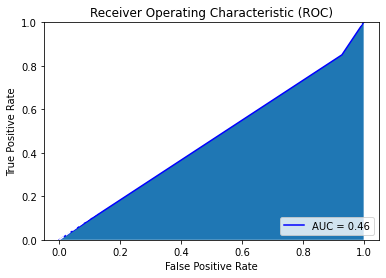

In [8]:
model = DecisionTreeClassifier(class_weight="balanced", criterion='gini', max_depth=2,max_features='auto', min_impurity_split=0.05, min_samples_leaf=1, min_samples_split=2, splitter='best')
train = original_loan_per_year[1993].copy()
test = original_loan_per_year[1994].copy()
model_performance(model, train, test, normalize = True)

#### Train: 1993-1994 | Test: 1995

AUC Score: 0.5961538461538463


Accuracy: 0.5444444444444444
Precision: 0.9111111111111111
Recall: 0.5256410256410257
F1score: 0.7317073170731707


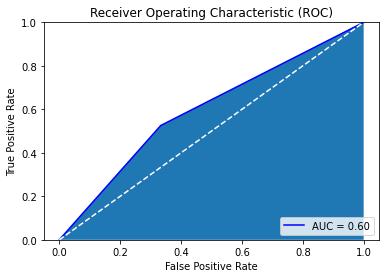

In [9]:
model = DecisionTreeClassifier(class_weight="balanced", criterion='gini', max_depth=2,max_features='auto', min_impurity_split=0.05, min_samples_leaf=1, min_samples_split=2, splitter='best')
train = pd.concat([original_loan_per_year[1993].copy(),original_loan_per_year[1994].copy()])
test = original_loan_per_year[1995].copy()
model_performance(model, train, test, normalize = True)

#### Train: 1993-1995 | Test: 1996

AUC Score: 0.5405321782178218


Accuracy: 0.6153846153846154
Precision: 0.8783783783783784
Recall: 0.6435643564356436
F1score: 0.8457142857142858


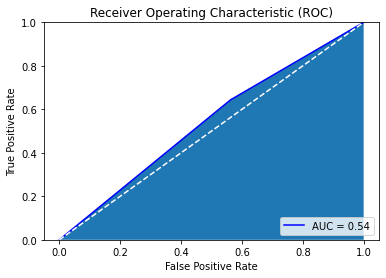

In [10]:
model = DecisionTreeClassifier(class_weight="balanced", criterion='entropy', max_depth=8,max_features='auto', min_impurity_split=0.23, min_samples_leaf=1, min_samples_split=6, splitter='best')
train = pd.concat([original_loan_per_year[1993].copy(),original_loan_per_year[1994].copy(),original_loan_per_year[1995].copy()])
test = original_loan_per_year[1996].copy()
model_performance(model, train, test, normalize = True)

### Gradient Boosting

#### Train: 1993 | Test: 1994

AUC Score: 0.48686371100164205


Accuracy: 0.42574257425742573
Precision: 0.8536585365853658
Recall: 0.40229885057471265
F1score: 0.640625


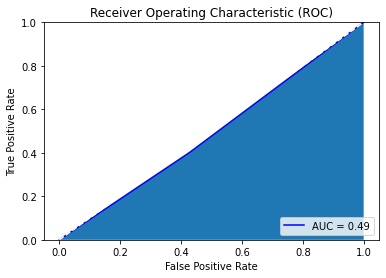

In [5]:
model = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, loss='deviance', max_depth=2, max_features='auto', min_impurity_split=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0, n_estimators=100, subsample=1)
train = original_loan_per_year[1993].copy()
test = original_loan_per_year[1994].copy()
model_performance(model, train, test, normalize = True)

#### Train: 1993-1994 | Test: 1995

AUC Score: 0.6378205128205128


Accuracy: 0.8
Precision: 0.9054054054054054
Recall: 0.8589743589743589
F1score: 0.9736842105263158


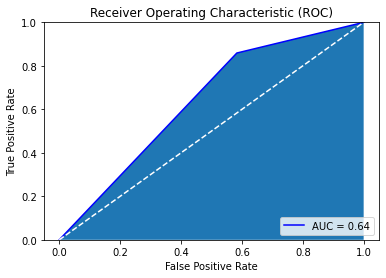

In [6]:
model = GradientBoostingClassifier()
train = pd.concat([original_loan_per_year[1993].copy(),original_loan_per_year[1994].copy()])
test = original_loan_per_year[1995].copy()
model_performance(model, train, test, normalize = True)

#### Train: 1993-1995 | Test: 1996

AUC Score: 0.6160272277227723


Accuracy: 0.5641025641025641
Precision: 0.9166666666666666
Recall: 0.5445544554455446
F1score: 0.7453416149068324


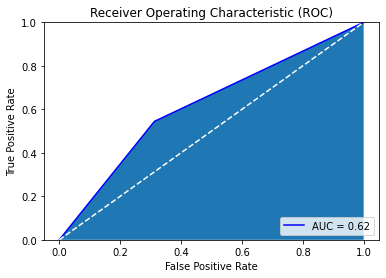

In [7]:
model = GradientBoostingClassifier()
train = pd.concat([original_loan_per_year[1993].copy(),original_loan_per_year[1994].copy(),original_loan_per_year[1995].copy()])
test = original_loan_per_year[1996].copy()
model_performance(model, train, test, normalize = True)

### Naive-Bayes

#### Train: 1993 | Test: 1994

In [ ]:
model = GaussianNB()
train = original_loan_per_year[1993].copy()
test = original_loan_per_year[1994].copy()

#### Train: 1993-1994 | Test: 1995

In [ ]:
model = GaussianNB()
train = pd.concat([original_loan_per_year[1993].copy(),original_loan_per_year[1994].copy()])
test = original_loan_per_year[1995].copy()


#### Train: 1993-1995 | Test: 1996

In [ ]:
model = GaussianNB()
train = pd.concat([original_loan_per_year[1993].copy(),original_loan_per_year[1994].copy(), original_loan_per_year[1995].copy()])
test = original_loan_per_year[1996].copy()

In [6]:
def normalize_columns(df, columns):
    for col in columns:
        col_min = df[col].min()
        col_max =  df[col].max()
        
        df[col] = (df[col] - col_min)/(col_max - col_min)